In [5]:
import matplotlib.pyplot as plt
import numpy as np
from tensorflow.keras.datasets import cifar10
from tensorflow import keras

import shap

#################
### Load Data ###
#################
# Model parameters
num_classes = 10

# The data, split between train and test sets:
(x_train, y_train), (x_test, y_test) = cifar10.load_data()
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test  = keras.utils.to_categorical(y_test, num_classes)

# Preprocess data
x_train = x_train.astype('float32')/255
x_test  = x_test.astype('float32')/255

##################
### Load Model ###
##################
from model import cifar_cnn
model = cifar_cnn()

x_train shape: (50000, 32, 32, 3)
50000 train samples
10000 test samples
313/313 [==============================] - 1s 4ms/step - loss: 0.7515 - accuracy: 0.7556
Test loss: 0.7514850497245789
Test accuracy: 0.7555999755859375


Actual Category: [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.], Predict Category: [[0.16149084 0.00278377 0.05986952 0.38650888 0.04066172 0.23362757
  0.05066403 0.04187843 0.01809059 0.0044246 ]]
***Black Baseline***
***Average Baseline***


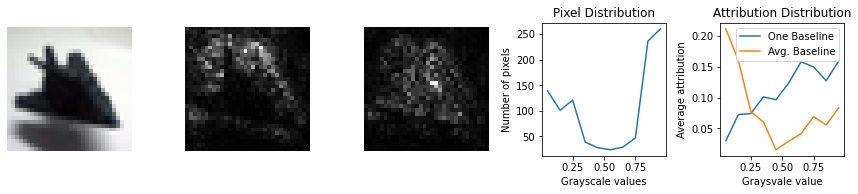

Actual Category: [0. 0. 1. 0. 0. 0. 0. 0. 0. 0.], Predict Category: [[6.6741492e-04 2.2181266e-06 9.9716574e-01 3.4143854e-04 4.3058518e-04
  1.2803000e-03 1.2956442e-06 1.0029040e-04 5.5072414e-06 5.1934767e-06]]
***Black Baseline***
***Average Baseline***


Mean of empty slice.
invalid value encountered in double_scalars
Mean of empty slice.
invalid value encountered in double_scalars


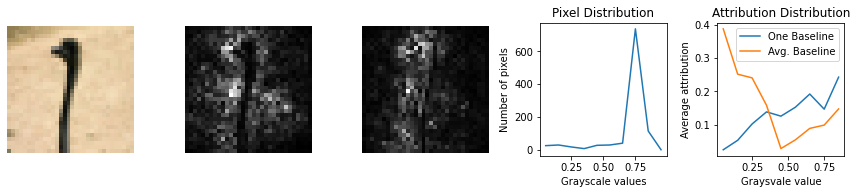

Actual Category: [0. 0. 0. 0. 0. 0. 0. 1. 0. 0.], Predict Category: [[4.26015845e-07 2.31302710e-09 2.40035479e-06 1.37525103e-06
  9.49752973e-07 2.92911482e-05 1.41150536e-09 9.99965310e-01
  7.94178126e-11 1.06024515e-07]]
***Black Baseline***
***Average Baseline***


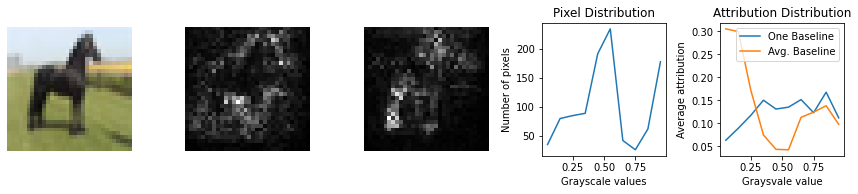

In [6]:
from path_explain import PathExplainerTF
explainer  = PathExplainerTF(model)
fig_path = "fig/int_grad/"

def pred_fn(x): 
    if len(x) == 0: return(np.zeros((1,num_classes)))
    return(model.predict(x.reshape((x.shape[0],32,32,3))))

def plot_img(img, is_gray=True):
    plt.axis('off')
    if is_gray:
        plt.imshow(img, cmap="gray", vmin=0, vmax=1)
    else:
        plt.imshow(img, vmin=0, vmax=1)
    plt.tight_layout()

nsamp = 2000
plt.rcParams["figure.figsize"] = (12,2.8)
for i in [29, 41, 172]:
    plt.clf()
    sample = x_train[i:i+1]
    label  = y_train[i]
    y_pred = model.predict(sample)
    print('Actual Category: %s, Predict Category: %s' % (label, y_pred))
    fname = "img{}.png".format(i)
    plt.subplot(1,5,1)
    plot_img(sample[0])

    ##################
    # Black baseline #
    ##################
    print("***Black Baseline***")
    class_sv   = explainer.attributions(inputs=sample, baseline=np.zeros(sample.shape), batch_size=100, num_samples=nsamp, 
                                        use_expectation=False, output_indices=[np.argmax(label)])[0]
    sv_img_one = np.abs(class_sv).mean(2)                         # Average across abs. val. channels
    sv_img_one = sv_img_one/sv_img_one.max()                      # Normalize
    plt.subplot(1,5,2)
    plot_img(sv_img_one, is_gray=True)

    ####################
    # Average baseline #
    ####################
    print("***Average Baseline***")
    class_sv   = explainer.attributions(inputs=sample, baseline=x_train, batch_size=100, num_samples=nsamp, 
                                        use_expectation=True, output_indices=[np.argmax(label)])[0]
    sv_img_avg = np.abs(class_sv).mean(2)                         # Average across abs. val. channels
    sv_img_avg = sv_img_avg/sv_img_avg.max()                      # Normalize
    plt.subplot(1,5,3)
    plot_img(sv_img_avg, is_gray=True)

    ####################################
    ### Quantitative measure of bias ###
    ####################################
    import cv2

    # Get gray scale version of the image
    gray = cv2.cvtColor(sample[0], cv2.COLOR_BGR2GRAY)

    # Get histograms
    counts, bins = np.histogram(gray.flatten(),bins=10, range=[0,1])
    bin_means    = (bins[:-1] + bins[1:])/2
    plt.subplot(1,5,4)
    plt.plot(bin_means, counts)
    plt.title("Pixel Distribution")
    plt.xlabel("Grayscale values")
    plt.ylabel("Number of pixels")
    plt.tight_layout()

    # Get attribution sums for one baseline
    plt.subplot(1,5,5)
    attr_sums = []
    for bin_left, bin_right in zip(bins[:-1], bins[1:]):
        within_bin = (gray >= bin_left) & (gray <= bin_right)
        attr_sums.append(sv_img_one[within_bin].mean())
    plt.plot(bin_means, attr_sums, label="One Baseline")

    # Get attribution sums for many baselines
    attr_sums = []
    for bin_left, bin_right in zip(bins[:-1], bins[1:]):
        within_bin = (gray >= bin_left) & (gray <= bin_right)
        attr_sums.append(sv_img_avg[within_bin].mean())
    plt.plot(bin_means, attr_sums, label="Avg. Baseline")

    # Title plot
    plt.title("Attribution Distribution")
    plt.xlabel("Graysvale value")
    plt.ylabel("Average attribution")
    plt.tight_layout()
    plt.legend()
    plt.savefig("{}img{}.pdf".format(fig_path,i), bbox_inches='tight', pad_inches=0.1)
    plt.show()